# RAG (Retrieval Augmented Generation)-learning DistilGPT-2 on the 'Diseases_Symptoms' Dataset

## 1. Importing Libraries

This section imports essential libraries for data manipulation, tokenization, model training and result visualization.

In [24]:
from datasets import load_dataset, DatasetDict, Dataset
import pandas as pd
import ast
import datasets
from tqdm import tqdm
import time
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ExponentialLR

## 2. Loading and Preprocessing the Dataset

The dataset is loaded using the `load_dataset()` function, and only the relevant columns ('Name', 'Symptoms', 'Treatments') are extracted.

In [25]:
data_sample = load_dataset("QuyenAnhDE/Diseases_Symptoms")
updated_data = [{'Name': item['Name'], 'Symptoms': item['Symptoms'], 'Treatments': item['Treatments']} for item in data_sample['train']]
df = pd.DataFrame(updated_data)

Repo card metadata block was not found. Setting CardData to empty.


## 3. Configuring the Device

The code checks for GPU availability using CUDA; otherwise, it defaults to CPU.

In [26]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## 4. Tokenizer and Model Initialization

A pre-trained DistilGPT-2 tokenizer and model are loaded using Hugging Face Transformers.

In [27]:
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')
model = GPT2LMHeadModel.from_pretrained('distilgpt2').to(device)
BATCH_SIZE = 16

## 5. Dataset Class Definition

The custom `LanguageDataset` class prepares the dataset by encoding input text into toke IDs using the tokenizer.

In [29]:
class LanguageDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.labels = df.columns #устанавливаем метки столбцов
        self.data = df.to_dict(orient='records')
        self.tokenizer = tokenizer
        self.max_length = 128

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx][self.labels[0]]
        y = self.data[idx][self.labels[1]]
        z = self.data[idx][self.labels[2]]
        text = f"{x} | {y} | {z}"

        tokens = self.tokenizer.encode_plus(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True) 
        
        return tokens

## 6. Splitting the Dataset

The dataset is split into training and validation sets with an 80/20 ratio.

In [30]:
data_sample = LanguageDataset(df, tokenizer)
train_size = int(0.8 * len(data_sample))
valid_size = len(data_sample) - train_size

train_data, valid_data = random_split(data_sample, [train_size, valid_size])
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True) #дополнительно перемешаем данные
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)

## 7. Training Configuration

Optimizer and result DataFrame are initialized.

In [31]:
num_epochs = 60
batch_size = BATCH_SIZE
model_name = 'distilgpt2'
gpu = 0
reshuffle_every = 6
optimizer = optim.Adam(model.parameters())
tokenizer.pad_token = tokenizer.eos_token
results = pd.DataFrame(columns=['epoch', 'transformer', 'batch_size', 'gpu',
                                'training_loss', 'validation_loss', 'epoch_duration_sec'])

## 8. Training and Validation Functions

- `reshuffle_data()`: Splits the dataset into training and validation sets.

- `train_model()`: Handles the model training and validation loops for each epoch.

In [32]:
def reshuffle_data(dataset):
    train_data, test_data = random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])
    return train_data, test_data

def train_model(model, num_epochs, train_loader, batch_size, model_name, scheduler, tokenizer, device):
  for epoch in range(num_epochs):
      start_time = time.time()  # Start the timer for the epoch
      if epoch % reshuffle_every == 0:
        train_data, test_data = reshuffle_data(data_sample)
        train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=16, shuffle=False)
      model.train() # Turn on the train-mode
      epoch_training_loss = 0

      train_iterator = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs} Batch Size: {batch_size}, Transformer: {model_name}")

      for batch in train_iterator:
          optimizer.zero_grad()
          inputs = batch['input_ids'].squeeze(1).to(device)
          targets = inputs.clone()

          outputs = model(input_ids=inputs, labels=targets)

          loss = outputs.loss
          
          loss.backward() #backprop
          optimizer.step() #weight update

          train_iterator.set_postfix({'Training Loss': loss.item()})
          epoch_training_loss += loss.item()

      avg_epoch_training_loss = epoch_training_loss / len(train_iterator)
      
      model.eval() #Turn on the eval-mode
      
      epoch_validation_loss = 0
      total_loss = 0
      valid_iterator = tqdm(valid_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}")
      with torch.no_grad():
          for batch in valid_iterator:
              inputs = batch['input_ids'].squeeze(1).to(device)
              targets = inputs.clone()
              outputs = model(input_ids=inputs, labels=targets)
              loss = outputs.loss
              total_loss += loss
              valid_iterator.set_postfix({'Validation Loss': loss.item()})
              epoch_validation_loss += loss.item()

      avg_epoch_validation_loss = epoch_validation_loss / len(valid_loader)

      end_time = time.time()  # End of the epoch
      epoch_duration_sec = end_time - start_time

      new_row = {'transformer': model_name,
                'batch_size': batch_size,
                'gpu': gpu,
                'epoch': epoch+1,
                'training_loss': avg_epoch_training_loss,
                'validation_loss': avg_epoch_validation_loss,
                'epoch_duration_sec': epoch_duration_sec}  

      results.loc[len(results)] = new_row
      print(f"Epoch: {epoch+1}, Validation Loss: {total_loss/len(valid_loader)}")

      print('last lr', scheduler.get_last_lr())
      scheduler.step()

## 9.Training the Model

The training process is executed using the `train_model()` function.

In [ ]:
scheduler = ExponentialLR(optimizer, gamma=0.85)
train_model(model, num_epochs, train_loader, batch_size, model_name, scheduler, tokenizer, device)

## 10. Text Generation

A sample input string is tokenized and passed to the model for text generation.

In [ ]:
input_str = "Cellulitis"
input_ids = tokenizer.encode(input_str, return_tensors='pt').to(device)

output = model.generate(
    input_ids,
    max_length=70,
    num_return_sequences=1,
    do_sample=True,
    top_k=10,
    top_p=0.8,
    temperature=1,
    repetition_penalty=1.2
)
decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)
print(decoded_output)

## 11. Visualizing Training and Validation Loss

The `results` DataFrame is used to plot the loss values for each epoch.

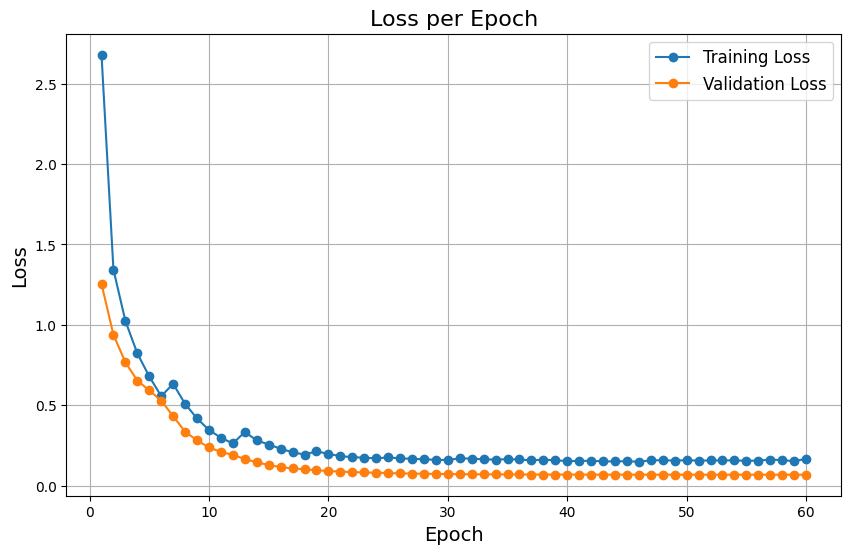

In [37]:
import matplotlib.pyplot as plt

# Extract loss values from the results DataFrame
epochs = results['epoch']
training_loss = results['training_loss']
validation_loss = results['validation_loss']

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')

# Add titles and labels
plt.title('Loss per Epoch', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()